# Elo Score Calculation

In [1]:
import re
import os
import sys
from collections import defaultdict

In [2]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import xlrd

In [4]:
# setting path
sys.path.append('../../src')

In [5]:
from eloscore import eloscore

In [6]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Summary

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Importing Data for One Sheet

- The original data has been trimmed so that only the cells with dates, winner ID's, and relevant metadata were kept

In [7]:
xls = pd.ExcelFile("./data/Tube_Test.xlsx")
sheets = xls.sheet_names

In [8]:
sheets

['summary', 'CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

In [9]:
tube_test_observations_df = pd.read_excel("./data/Tube_Test.xlsx", sheet_name=sheets[1], header=1)

In [10]:
copy_tube_test_observations_df = tube_test_observations_df.copy()

In [11]:
tube_test_observations_df.head()

,runner,date,match,winner,loser,notes,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Ezra,2022-07-11,1vs2,2.0,1.0,NaN,NaN,NaN,NaN
1,NaN,NaT,2vs3,2.0,3.0,NaN,NaN,NaN,NaN
2,NaN,NaT,3vs4,3.0,4.0,NaN,NaN,NaN,NaN
3,NaN,NaT,1vs3,3.0,1.0,NaN,NaN,NaN,NaN
4,NaN,NaT,2vs4,2.0,4.0,NaN,NaN,NaN,NaN


## Adding the session number

- Each new session has the date as a row, so we will get the index of all the rows with dates

In [12]:
tube_test_observations_df.dropna(axis=0, subset="date")

,runner,date,match,winner,loser,notes,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Ezra,2022-07-11,1vs2,2.0,1.0,NaN,NaN,NaN,NaN
6,Catalina,2022-07-12,3vs2,2.0,3.0,NaN,NaN,NaN,NaN
12,Nancy,2022-07-13,4vs3,3.0,4.0,NaN,NaN,NaN,NaN
18,Ezra,2022-07-14,2vs3,2.0,3.0,NaN,NaN,NaN,NaN
24,Erika,2022-07-15,1vs4,1.0,4.0,NaN,NaN,NaN,NaN
30,Naeliz,2022-07-18,1vs2,1.0,2.0,* started at 1pm,NaN,NaN,NaN
36,Catalina,2022-07-20,3vs2,2.0,3.0,NaN,NaN,NaN,NaN
42,Isabel,2022-07-23,4vs3,3.0,4.0,NaN,NaN,NaN,NaN
48,Jocelyn,2022-07-24,1vs4,1.0,4.0,"Tube testing began before reward training, as ...",NaN,NaN,NaN
54,Jocelyn,2022-07-25,2vs3,2.0,3.0,NaN,NaN,NaN,NaN


- Getting the indexes of where each new session starts

In [13]:
tube_test_observations_df.dropna(axis=0, subset="date").index

Int64Index([0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78], dtype='int64')

In [14]:
session_indexes = tube_test_observations_df.dropna(axis=0, subset="date").index

- Adding a column for the session number and then filling all the `NaNs`

In [15]:
tube_test_observations_df = eloscore.add_session_number_column(tube_test_observations_df, session_indexes)
tube_test_observations_df = tube_test_observations_df.fillna(method='ffill')

- Making another column for plotting

In [16]:
tube_test_observations_df = eloscore.add_session_number_column(tube_test_observations_df, session_indexes, session_number_column="session_number_plotting")

In [17]:
tube_test_observations_df.head()

,runner,date,match,winner,loser,notes,Unnamed: 6,Unnamed: 7,Unnamed: 8,session_number,session_number_plotting
0,Ezra,2022-07-11,1vs2,2.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0
1,Ezra,2022-07-11,2vs3,2.0,3.0,NaN,NaN,NaN,NaN,1.0,NaN
2,Ezra,2022-07-11,3vs4,3.0,4.0,NaN,NaN,NaN,NaN,1.0,NaN
3,Ezra,2022-07-11,1vs3,3.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
4,Ezra,2022-07-11,2vs4,2.0,4.0,NaN,NaN,NaN,NaN,1.0,NaN


## Calculating ELO Score

- Example calculation

In [18]:
eloscore.calculate_elo_score(subject_elo_score=1000, agent_elo_score=2000)

1020

## Get the Elo score for all the events

In [19]:
tube_test_observations_df.head()

,runner,date,match,winner,loser,notes,Unnamed: 6,Unnamed: 7,Unnamed: 8,session_number,session_number_plotting
0,Ezra,2022-07-11,1vs2,2.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0
1,Ezra,2022-07-11,2vs3,2.0,3.0,NaN,NaN,NaN,NaN,1.0,NaN
2,Ezra,2022-07-11,3vs4,3.0,4.0,NaN,NaN,NaN,NaN,1.0,NaN
3,Ezra,2022-07-11,1vs3,3.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
4,Ezra,2022-07-11,2vs4,2.0,4.0,NaN,NaN,NaN,NaN,1.0,NaN


In [20]:
eloscore.update_elo_score(winner_id="A", loser_id="B")

defaultdict(<function eloscore.eloscore.update_elo_score.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

- Function that creates a dictionary that has the original/updated elo score for each event

In [21]:
index_to_elo_score_and_meta_data = eloscore.iterate_elo_score_calculation_for_data_frame(data_frame=tube_test_observations_df, winner_column="winner", loser_column="loser", additional_columns=["date", "session_number", "session_number_plotting"])

In [22]:
index_to_elo_score_and_meta_data[0]

{'total_match_number': 1,
 'subject_id': 2.0,
 'agent_id': 1.0,
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1,
 'date': Timestamp('2022-07-11 00:00:00'),
 'session_number': 1.0,
 'session_number_plotting': 1.0}

- Turning the dictionary into a dataframe

In [23]:
tube_test_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [24]:
tube_test_elo_score_df.head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
0,1,2.0,1.0,1000.0,1010.0,1,2022-07-11,1.0,1.0
1,1,1.0,1.0,1000.0,990.0,1,2022-07-11,1.0,1.0
2,2,2.0,3.0,1010.0,1019.7,1,2022-07-11,1.0,NaN
3,2,3.0,3.0,1000.0,990.3,1,2022-07-11,1.0,NaN
4,3,3.0,4.0,990.3,1000.6,1,2022-07-11,1.0,NaN


In [25]:
tube_test_elo_score_df.tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
175,88,2.0,2.0,1060.0,1053.1,1,2022-07-29,14.0,NaN
176,89,1.0,2.0,1179.4,1185.9,1,2022-07-29,14.0,NaN
177,89,2.0,2.0,1053.1,1046.6,1,2022-07-29,14.0,NaN
178,90,1.0,2.0,1185.9,1192.1,1,2022-07-29,14.0,NaN
179,90,2.0,2.0,1046.6,1040.4,1,2022-07-29,14.0,NaN


In [26]:
tube_test_elo_score_df.groupby("subject_id").count()

,total_match_number,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
subject_id,,,,,,,,
1.0,48,48,48,48,48,48,48,6
2.0,48,48,48,48,48,48,48,8
3.0,42,42,42,42,42,42,42,8
4.0,42,42,42,42,42,42,42,6


In [27]:
tube_test_elo_score_df.groupby("session_number").count()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number_plotting
session_number,,,,,,,,
1.0,12,12,12,12,12,12,12,2
2.0,12,12,12,12,12,12,12,2
3.0,12,12,12,12,12,12,12,2
4.0,12,12,12,12,12,12,12,2
5.0,12,12,12,12,12,12,12,2
6.0,12,12,12,12,12,12,12,2
7.0,12,12,12,12,12,12,12,2
8.0,12,12,12,12,12,12,12,2
9.0,12,12,12,12,12,12,12,2


# Plotting the Elo Score by match number

In [28]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

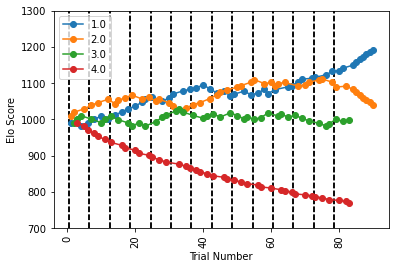

In [29]:
fig, ax = plt.subplots()

# Drawing vertical lines that represent when each session begins
for index, row in tube_test_elo_score_df.dropna(subset=["session_number_plotting"]).iterrows():
    # Offsetting by 0.5 to avoid drawing the line on the dot
    plt.vlines(x=[row["total_match_number"] - 0.5], ymin=700, ymax=1300, colors='black', linestyle='dashed')

# Drawing a line for each subject
for subject in sorted(tube_test_elo_score_df["subject_id"].unique()):
    # Getting all the rows with the current subject
    subject_df = tube_test_elo_score_df[tube_test_elo_score_df["subject_id"] == subject]
    # Making the dates into days after the first session by subtracting all the dates by the first date
    plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

# Labeling the X/Y Axis and the title
ax.set_xlabel("Trial Number")
ax.set_ylabel("Elo Score")
# ax.set_title("Elo Score for Home Cage Observation: Cage {}".format(cage))
# To show the legend
ax.legend()
plt.xticks(rotation=90)
plt.ylim(700, 1300) 
plt.show()



# Calculate the Elo Score for all sheets

In [30]:
xls = pd.ExcelFile("./data/Tube_Test.xlsx")
sheets = xls.sheet_names

In [31]:
sheets

['summary', 'CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

In [32]:
sheet_to_data_frame = defaultdict(dict)
for sheet in sheets[1:]:
    sheet_to_data_frame[sheet]["recording_data_frame"] = pd.read_excel("./data/Tube_Test.xlsx", sheet_name=sheet, header=1).copy()
    
    sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].dropna(subset=["winner"])
    # Adding the session numbers as a column
    session_indexes = sheet_to_data_frame[sheet]["recording_data_frame"].dropna(axis=0, subset="date").index
    sheet_to_data_frame[sheet]["recording_data_frame"] = eloscore.add_session_number_column(sheet_to_data_frame[sheet]["recording_data_frame"], session_indexes)
    sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].fillna(method='ffill')
    sheet_to_data_frame[sheet]["recording_data_frame"] = eloscore.add_session_number_column(sheet_to_data_frame[sheet]["recording_data_frame"], session_indexes, session_number_column="session_number_plotting")

    # Splitting all the rows with commas in the ID
    sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].astype(str)
    sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].astype(str)
    
    sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].str.split(",")
    sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].explode("winner").reset_index(drop=True)
    sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].str.split(",")
    sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].explode("loser").reset_index(drop=True)

    sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].astype(float).astype(int).astype(str)
    sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].astype(float).astype(int).astype(str)
    
    # Calculating the Elo Score    
    index_to_elo_score_and_meta_data = eloscore.iterate_elo_score_calculation_for_data_frame(data_frame=sheet_to_data_frame[sheet]["recording_data_frame"], \
                                                                                                               winner_column="winner", loser_column="loser", additional_columns=["date", "session_number", "session_number_plotting"])
    sheet_to_data_frame[sheet]["elo_score_data_frame"] = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

## Saving the Elo Score Dataframes

- Create folders to save processed data

- Adding the cage information for each cage

In [33]:
for key, value in sheet_to_data_frame.items():    
    cage_number = re.findall(r'\d+', key)[0]
    sheet_to_data_frame[key]["elo_score_data_frame"]["cage"] = cage_number
    sheet_to_data_frame[key]["elo_score_data_frame"]["id_with_cage_number"] = sheet_to_data_frame[key]["elo_score_data_frame"]["subject_id"].apply(lambda x: cage_number + "." + x)
    sheet_to_data_frame[key]["elo_score_data_frame"]["experiment_type"] = "tube_test"

In [34]:
sheet_to_data_frame[sheet]["elo_score_data_frame"].head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting,cage,id_with_cage_number,experiment_type
0,1,2,1,1000.0,1010.0,1,2022-07-11,1.0,1.0,6,6.2,tube_test
1,1,1,1,1000.0,990.0,1,2022-07-11,1.0,1.0,6,6.1,tube_test
2,2,2,3,1010.0,1019.7,1,2022-07-11,1.0,NaN,6,6.2,tube_test
3,2,3,3,1000.0,990.3,1,2022-07-11,1.0,NaN,6,6.3,tube_test
4,3,4,3,1000.0,1009.7,1,2022-07-11,1.0,NaN,6,6.4,tube_test


In [35]:
all_sheet_elo_scord_df_list = []
for key, value in sheet_to_data_frame.items():    
    all_sheet_elo_scord_df_list.append(sheet_to_data_frame[key]["elo_score_data_frame"])

In [36]:
all_sheet_elo_scord_df_combined = pd.concat(all_sheet_elo_scord_df_list)

In [37]:
all_sheet_elo_scord_df_combined["id_with_cage_number"].unique()

array(['1.2', '1.1', '1.3', '1.4', '2.1', '2.2', '2.3', '2.4', '3.1',
       '3.2', '3.3', '3.4', '4.1', '4.2', '4.3', '4.4', '5.2', '5.1',
       '5.3', '5.4', '6.2', '6.1', '6.3', '6.4'], dtype=object)

In [38]:
id_to_final_elo_score_dict = defaultdict(dict)
for id_with_cage_number in all_sheet_elo_scord_df_combined["id_with_cage_number"].unique():
    per_subject_df = all_sheet_elo_scord_df_combined[all_sheet_elo_scord_df_combined["id_with_cage_number"] == id_with_cage_number]
    id_to_final_elo_score_dict[id_with_cage_number]["final_elo_score"] = per_subject_df.iloc[-1]["updated_elo_score"]

In [39]:
id_to_final_elo_score_df = pd.DataFrame.from_dict(id_to_final_elo_score_dict, orient="index")
id_to_final_elo_score_df["experiment_type"] = "tube_test"

In [40]:
id_to_final_elo_score_df["id_with_cage_number"] = id_to_final_elo_score_df.index
id_to_final_elo_score_df = id_to_final_elo_score_df.reset_index(drop=True)

In [41]:
id_to_final_elo_score_df.head()

,final_elo_score,experiment_type,id_with_cage_number
0,1149.5,tube_test,1.1
1,1083.0,tube_test,1.2
2,998.5,tube_test,1.3
3,769.0,tube_test,1.4
4,997.5,tube_test,2.1


# Making plots for all sheets

- Getting the dates the files were being recorded to use for the file name

In [42]:
sheets[1]

'CAGE1'

In [43]:
earliest_date = str(sheet_to_data_frame[sheets[1]]["recording_data_frame"]["date"].min()).split()[0]

In [44]:
latest_date = str(sheet_to_data_frame[sheets[1]]["recording_data_frame"]["date"].max()).split()[0]

In [45]:
earliest_date

'2022-07-11'

In [46]:
latest_date

'2022-07-29'

- Getting the cage numbers

In [47]:
all_cages = "_".join(sorted([sheet.lower().strip("cage").strip() for sheet in sheets[1:]]))

In [48]:
all_cages

'1_2_3_4_5_6'

In [49]:
output_directory = "./proc/plots/tube_test_elo_score/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [50]:
output_directory

'./proc/plots/tube_test_elo_score/cage_1_2_3_4_5_6_date_2022-07-11_2022-07-29'

In [51]:
os.makedirs(output_directory, exist_ok=True)

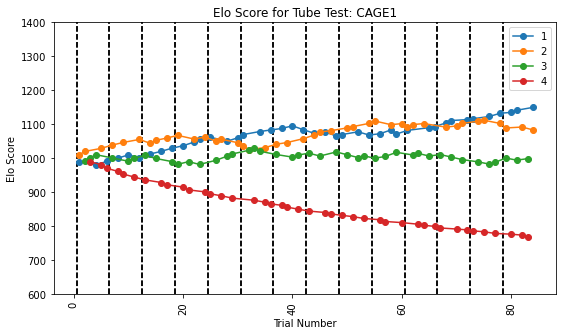

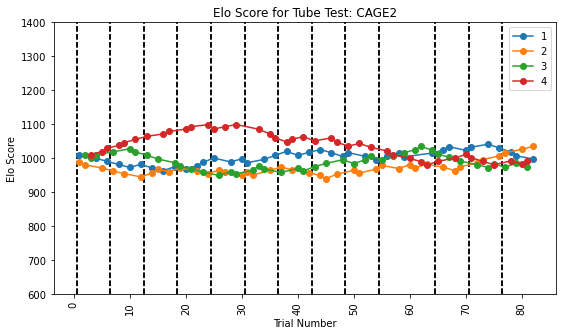

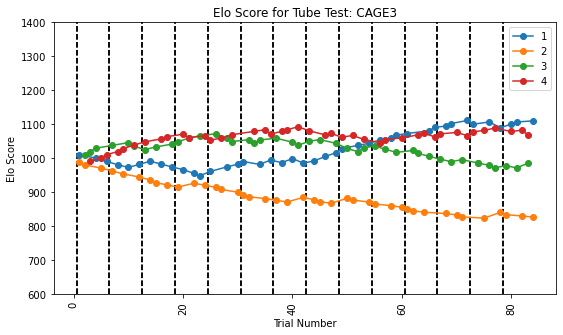

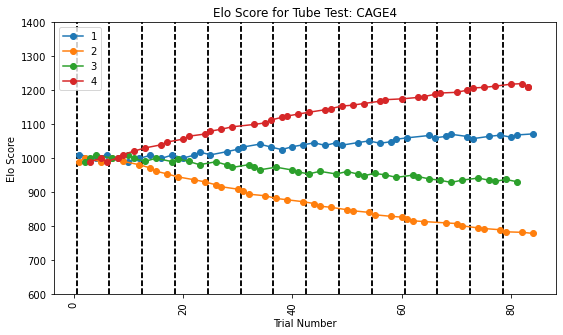

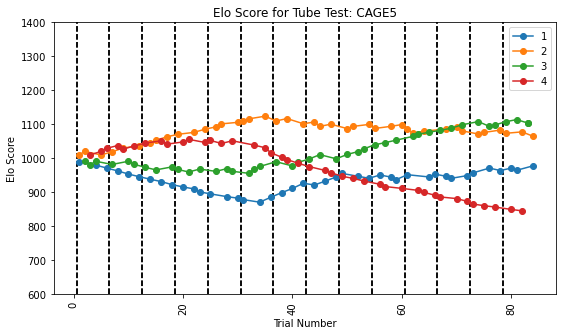

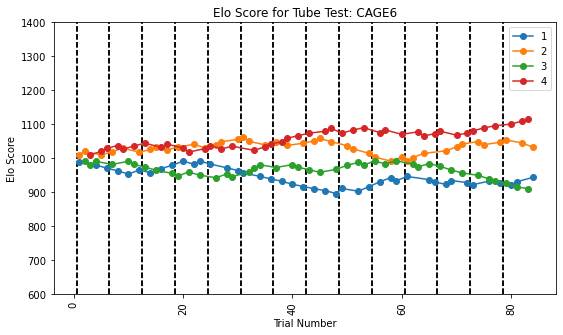

In [52]:
for key, value in sheet_to_data_frame.items():
    plt.rcParams["figure.figsize"] = (9,5)
    elo_score_data_frame = value["elo_score_data_frame"]
    fig, ax = plt.subplots()

    # Drawing vertical lines that represent when each session begins
    for index, row in elo_score_data_frame.dropna(subset=["session_number_plotting"]).iterrows():
        # Offsetting by 0.5 to avoid drawing the line on the dot
        plt.vlines(x=[row["total_match_number"] - 0.5], ymin=600, ymax=1400, colors='black', linestyle='dashed')

    # Drawing a line for each subject
    for subject in sorted(elo_score_data_frame["subject_id"].astype(str).unique()):
        # Getting all the rows with the current subject
        subject_df = elo_score_data_frame[elo_score_data_frame["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Tube Test: {}".format(key))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(600, 1400) 
    
    file_name = "tube_test_elo_score_{}_date_{}_{}.png".format(key, earliest_date, latest_date)
    plt.savefig(os.path.join(output_directory, file_name))
    
    plt.show()


# Saving the Dataframes

In [53]:
output_directory = "./proc/elo_score_spread_sheets/tube_test_elo_score/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [54]:
output_directory

'./proc/elo_score_spread_sheets/tube_test_elo_score/cage_1_2_3_4_5_6_date_2022-07-11_2022-07-29'

In [55]:
os.makedirs(output_directory, exist_ok=True)

In [56]:
file_name = "tube_test_elo_score_history_cages_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date)
all_sheet_elo_scord_df_combined.to_csv(os.path.join(output_directory, file_name))

In [57]:
file_name = "tube_test_final_elo_score_cages_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date)
id_to_final_elo_score_df.to_csv(os.path.join(output_directory, file_name))